In [1]:
## running once
%load_ext autoreload
%autoreload 2

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import os
from toolz.curried import *
import matplotlib.pyplot as plt
import seaborn as sns

## Loading dataset

In [3]:
from util import *

In [4]:
year, month = 2021, 6
carpark_dir = "/home_nfs/jiangyue/data/carparking"
month_dir = os.path.join(carpark_dir, f"{year}/{month:02}")
carpark_meta = load_carpark_meta(os.path.join(carpark_dir, "carpark_meta_three_weeks.geojson"))

In [5]:
#carpark_meta

#carpark_meta[carpark_meta.Agency == "HDB"]

#carpark_meta[carpark_meta.Agency == "URA"]

#carpark_meta[carpark_meta.Agency == "LTA"].head()

In [6]:
%%time
carpark_data_names = [
    "carpark_data_2021_06_01-21.json",
    #"carpark_data_2021_04_21-25.json",
    #"carpark_data_2021_04_26-30.json"
]

carpark_data = load_carpark_data_list(
    [os.path.join(carpark_dir, name) for name in carpark_data_names]
)

Loading /home_nfs/jiangyue/data/carparking/carpark_data_2021_06_01-21.json
CPU times: user 12min 45s, sys: 1min 9s, total: 13min 55s
Wall time: 13min 54s


In [7]:
carpark_data_o = carpark_data.copy()
carpark_data_o.reset_index(inplace=True)
carpark_data_o.rename(columns={"tid": "date"}, inplace=True)

carpark_data = carpark_remove_outlier(carpark_data)
carpark_data = carpark_data.fillna(method="ffill")

100%|██████████| 1918/1918 [17:28<00:00,  1.83it/s]


In [8]:
carpark_data = carpark_add_date(carpark_data)
carpark_data = carpark_remove_constant(carpark_data)
carpark_data["min"] = (carpark_data.tid % 1440 // 5).astype(str)
len(carpark_data.sid.unique())

1843

In [9]:
#constant_sids = np.setdiff1d(carpark_meta.sid, carpark_data.sid.unique())
#carpark_meta[carpark_meta.sid.isin(constant_sids)]

## Visualization

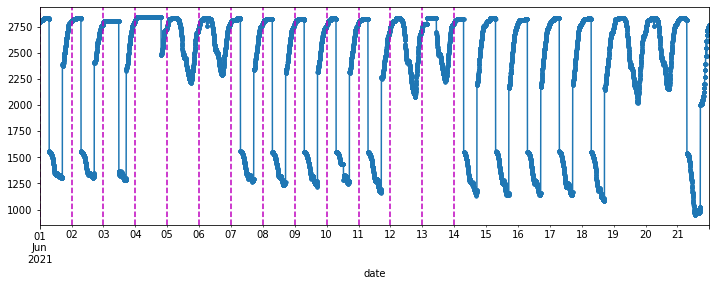

In [10]:
xs = pd.date_range("2021-06-01", periods=14)
ts = carpark_data[carpark_data.sid == 0].set_index("date")["AvailableLots"]
ts.plot(figsize=(12, 4), style=".-")
for x in xs:
    plt.axvline(x=x, linestyle='--', color="m")

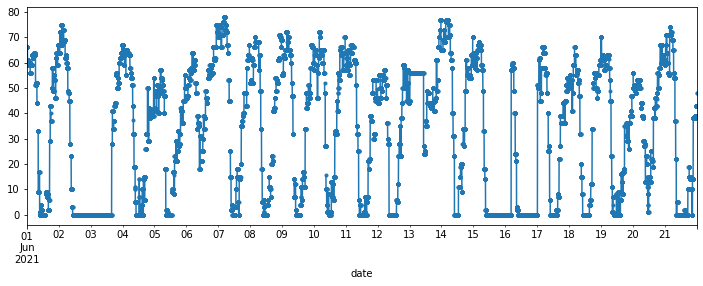

In [89]:
xs = pd.date_range("2021-04-26", periods=13)
ts = carpark_data_o[carpark_data_o.sid == 53].set_index("date")["AvailableLots"]
ts.plot(figsize=(12, 4), style=".-")
for x in xs:
    plt.axvline(x=x, linestyle='--', color="m")

In [90]:
carpark_data['Weekday']=carpark_data['date'].dt.dayofweek.astype(str)
df = pd.merge(carpark_data,carpark_meta[['sid','Agency']],on='sid', how='left') #label HDB and Non HDB data
df['Agency'] = df.Agency.map(lambda x: 1 if x =='HDB' else 0).astype(str)
carpark_data_uni = df
carpark_data_HDB = df[df.Agency == '1']
carpark_data_non_HDB = df[df.Agency != '1']


In [91]:
carpark_data_HDB.head()

,sid,tid,AvailableLots,date,min,Weekday,Agency
1300320,43,0,3.0,2021-06-01 00:00:00,0,1,1
1300321,43,1,3.0,2021-06-01 00:01:00,0,1,1
1300322,43,2,3.0,2021-06-01 00:02:00,0,1,1
1300323,43,3,3.0,2021-06-01 00:03:00,0,1,1
1300324,43,4,3.0,2021-06-01 00:04:00,0,1,1


In [92]:
# ts = carpark_data_o[carpark_data_o.sid == 45].set_index("date")["AvailableLots"]
# xs = ts[ts.diff().abs() > 100].index
# ts[sorted(np.concatenate([xs, xs - np.timedelta64(1, "m")]))]

# carpark_meta[carpark_meta.sid == 45]

## Forecasting

In [93]:
import warnings
warnings.filterwarnings("ignore")

In [94]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping
import torch
from torch.utils.data import DataLoader

from pytorch_forecasting import Baseline, NBeats, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE
from dataloader import subset_sampler

In [95]:
# carpark_data_s=carpark_data[carpark_data.sid==1000]

In [96]:
context_length = 12*60
prediction_length = 2*60

training_cutoff = 17*24*60
validation_cutoff = 19*24*60
test_cutoff = 21*24*60

training = TimeSeriesDataSet(
    carpark_data_uni[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data_uni[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data_uni,
    min_prediction_idx=validation_cutoff + 1
)

In [97]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)
# train_sampler = subset_sampler(training, 0.5, random=True)
# val_sampler = subset_sampler(validation, 0.05)
# test_sampler = subset_sampler(test, 0.05)

In [98]:
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)            
# train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
#                                           num_workers=8)                                          
# val_dataloader = validation.to_dataloader(batch_size=50, num_workers=8,
#                                           shuffle=False, sampler=val_sampler)                                          
# test_dataloader = test.to_dataloader(batch_size=50, num_workers=8,
#                                      shuffle=False, sampler=test_sampler)                                                                  

In [99]:
print(len(train_dataloader))
print(len(val_dataloader))
print(len(test_dataloader))

217861
508
508


In [100]:
# x_trn, y_trn = first(train_dataloader)
# x_val, y_val = first(val_dataloader)
# x_tst, y_tst = first(test_dataloader)

# x_trn["encoder_cat"].shape

# x_trn["decoder_cont"].shape

# x_trn["decoder_target"]

# rnn.output_transformer(dict(prediction=x_trn["decoder_cont"],
#                             target_scale=x_trn["target_scale"])).squeeze()
# training.target_normalizer(dict(prediction=x_trn["decoder_cont"],
#                                 target_scale=x_trn["target_scale"])).squeeze()

In [101]:
#training.index

In [102]:
# from pytorch_forecasting import Baseline

# baseline_predictions = Baseline().predict(test_dataloader)

# abs_error = torch.abs(baseline_predictions - actuals)

# print(torch.mean(abs_error * mask))
# errors = torch.mean(abs_error * mask, dim=0)

# mape = abs_error / (actuals + 1e-5)

# print(torch.mean(mape * mask))
# mapes = torch.mean(mape * mask, dim=0)

# plt.plot(torch.arange(1, len(errors)+1), errors, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAE")

# plt.plot(torch.arange(1, len(mapes)+1), mapes, ".-")
# plt.xlabel("Time steps")
# plt.ylabel("MAPE")

In [103]:
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0

### LSTM

In [104]:
from models import RNN

In [105]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91), "Weekday": (7, 20), "Agency": (2,2)},
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [106]:
print(rnn.lagged_target_positions)

{}


In [107]:
trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.4 K
3 | rnn              | GRU            | 40.2 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [108]:
rnn.hparams

"categorical_groups":                {}
"cell_type":                         GRU
"dropout":                           0.1
"embedding_labels":                  {'Agency': {'0': 0, '1': 1}, 'min': {'0': 0, '1': 1, '10': 2, '100': 3, '101': 4, '102': 5, '103': 6, '104': 7, '105': 8, '106': 9, '107': 10, '108': 11, '109': 12, '11': 13, '110': 14, '111': 15, '112': 16, '113': 17, '114': 18, '115': 19, '116': 20, '117': 21, '118': 22, '119': 23, '12': 24, '120': 25, '121': 26, '122': 27, '123': 28, '124': 29, '125': 30, '126': 31, '127': 32, '128': 33, '129': 34, '13': 35, '130': 36, '131': 37, '132': 38, '133': 39, '134': 40, '135': 41, '136': 42, '137': 43, '138': 44, '139': 45, '14': 46, '140': 47, '141': 48, '142': 49, '143': 50, '144': 51, '145': 52, '146': 53, '147': 54, '148': 55, '149': 56, '15': 57, '150': 58, '151': 59, '152': 60, '153': 61, '154': 62, '155': 63, '156': 64, '157': 65, '158': 66, '159': 67, '16': 68, '160': 69, '161': 70, '162': 71, '163': 72, '164': 73, '165': 74, 

In [109]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_50/checkpoints/epoch=2-step=1499.ckpt
cuda:0


In [110]:
%%time
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)

Predict:   0%|          | 0/508 [00:00<?, ? batches/s]

torch.Size([254000, 120])
CPU times: user 45.1 s, sys: 11 s, total: 56.1 s
Wall time: 53.9 s


In [111]:
abs_error = torch.abs(predictions - actuals)

In [112]:
abs_error.shape

torch.Size([254000, 120])

In [113]:
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)

tensor(7.0466)


In [114]:
abs_error_steps.shape

torch.Size([120])

In [115]:
mape = abs_error / (actuals + 1e-5)

In [116]:
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)

tensor(0.1070)


Text(0, 0.5, 'MAE')

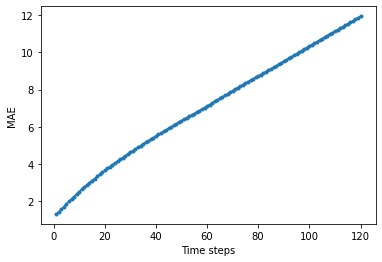

In [117]:
plt.plot(torch.arange(1, len(abs_error_steps)+1), abs_error_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [118]:
abs_error_steps

tensor([ 1.3112,  1.4134,  1.5514,  1.6994,  1.8423,  1.9810,  2.1155,  2.2484,
         2.3774,  2.5047,  2.6357,  2.7618,  2.8785,  2.9981,  3.1080,  3.2145,
         3.3262,  3.4337,  3.5440,  3.6500,  3.7568,  3.8574,  3.9578,  4.0534,
         4.1521,  4.2461,  4.3391,  4.4371,  4.5364,  4.6301,  4.7192,  4.8039,
         4.8923,  4.9850,  5.0775,  5.1647,  5.2488,  5.3325,  5.4147,  5.5000,
         5.5861,  5.6693,  5.7574,  5.8358,  5.9173,  5.9934,  6.0744,  6.1663,
         6.2499,  6.3300,  6.4108,  6.4856,  6.5584,  6.6353,  6.7121,  6.7945,
         6.8690,  6.9463,  7.0376,  7.1194,  7.1989,  7.2779,  7.3688,  7.4438,
         7.5297,  7.6086,  7.6899,  7.7764,  7.8666,  7.9463,  8.0251,  8.1128,
         8.1910,  8.2722,  8.3514,  8.4250,  8.5028,  8.5780,  8.6597,  8.7362,
         8.8149,  8.8901,  8.9719,  9.0503,  9.1243,  9.1996,  9.2830,  9.3637,
         9.4440,  9.5212,  9.6019,  9.6860,  9.7689,  9.8489,  9.9415, 10.0254,
        10.1068, 10.1872, 10.2636, 10.34

Text(0, 0.5, 'MAPE')

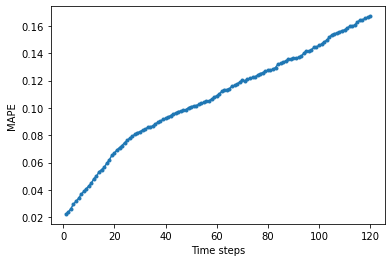

In [119]:
plt.plot(torch.arange(1, len(mape_steps)+1), mape_steps, ".-")
plt.xlabel("Time steps")
plt.ylabel("MAPE")
#plt.xlim([1, 120])
#plt.xticks([1, 20, 40, 60, 80, 100, 120]);

In [120]:
n = abs_error.shape[0]

In [121]:
step = 30 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()

μ = 4.6301, σ = 9.2345, max = 962.0601


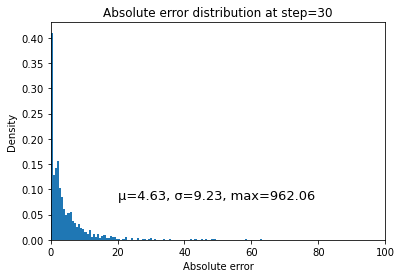

In [122]:
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

In [123]:
# raw_predictions, x = best_model.predict(test_dataloader, mode="raw", return_x=True, 
#                                         fast_dev_run=True)

# for idx in range(5, 10):
#     best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True);

Evaluating the Unified model on HDB dataset and Non-HDB dataset

Predict:   0%|          | 0/474 [00:00<?, ? batches/s]

torch.Size([237000, 120])
tensor(7.7710)
tensor(0.1102)
μ = 4.9403, σ = 8.4498, max = 628.5154, error rate = 0.0193


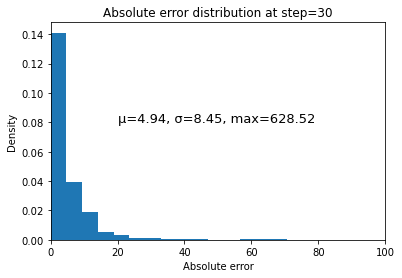

In [127]:
context_length = 12*60
prediction_length = 2*60

training_cutoff = 17*24*60
validation_cutoff = 19*24*60
test_cutoff = 21*24*60

test_HDB = TimeSeriesDataSet(
    carpark_data_HDB,
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
        min_prediction_idx=validation_cutoff + 1
)

test_HDB_sampler = subset_sampler(test_HDB, 0.05)
test_HDB_dataloader = test_HDB.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_HDB_sampler) 
predictions = best_model.predict(test_HDB_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_HDB_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 30 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

Unified model to predict non-HDB dataset

Predict:   0%|          | 0/33 [00:00<?, ? batches/s]

torch.Size([16500, 120])
tensor(11.6196)
tensor(0.1734)
μ = 7.5292, σ = 25.5452, max = 1295.3052, error rate = 0.0244


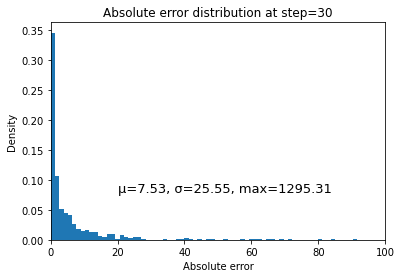

In [128]:
context_length = 12*60
prediction_length = 2*60

training_cutoff = 17*24*60
validation_cutoff = 19*24*60
test_cutoff = 21*24*60

test_non_HDB = TimeSeriesDataSet(
    carpark_data_non_HDB,
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    static_categoricals = ["Agency"],
    time_varying_known_categoricals=["min", "Weekday"],
        min_prediction_idx=validation_cutoff + 1
)

test_non_HDB_sampler = subset_sampler(test_non_HDB, 0.05)
test_non_HDB_dataloader = test_non_HDB.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_non_HDB_sampler) 
predictions = best_model.predict(test_non_HDB_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_non_HDB_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 30 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_non_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

HDB Model 

In [129]:
context_length = 12*60
prediction_length = 2*60

training_cutoff = 17*24*60
validation_cutoff = 19*24*60
test_cutoff = 21*24*60

training = TimeSeriesDataSet(
    carpark_data_HDB[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["min", "Weekday"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data_HDB[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data_HDB,
    min_prediction_idx=validation_cutoff + 1
)

In [130]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)   
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91), "Weekday": (7, 20)},
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.3 K
3 | rnn              | GRU            | 39.9 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
66.3 K    Trainable params
0         Non-trainable params
66.3 K    Total params
0.265     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_51/checkpoints/epoch=4-step=2499.ckpt
cuda:0


Predict:   0%|          | 0/474 [00:00<?, ? batches/s]

torch.Size([237000, 120])
tensor(6.7186)
tensor(0.1000)
μ = 4.3882, σ = 8.0873, max = 633.7255, error rate = 0.0172


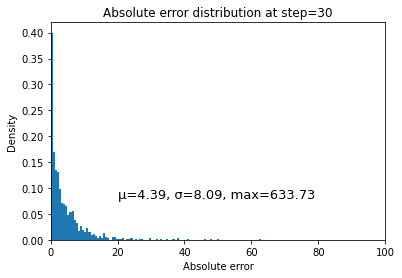

In [131]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 30 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

NON-HDB Model

In [136]:
context_length = 12*60
prediction_length = 2*60

training_cutoff = 17*24*60
validation_cutoff = 19*24*60
test_cutoff = 21*24*60

training = TimeSeriesDataSet(
    carpark_data_non_HDB[lambda x: x.tid <= training_cutoff],
    time_idx="tid",
    group_ids=["sid"],
    target="AvailableLots",
    time_varying_unknown_reals=["AvailableLots"],
    max_encoder_length=context_length,
    max_prediction_length=prediction_length,
    time_varying_known_categoricals=["min", "Weekday"],
)

validation = TimeSeriesDataSet.from_dataset(
    training,                                         
    carpark_data_non_HDB[lambda x: x.tid <= validation_cutoff],
    min_prediction_idx=training_cutoff + 1
)

test = TimeSeriesDataSet.from_dataset(
    training, 
    carpark_data_non_HDB,
    min_prediction_idx=validation_cutoff + 1
)

In [137]:
train_sampler = subset_sampler(training, 0.5, random=True)
val_sampler = subset_sampler(validation, 0.05)
test_sampler = subset_sampler(test, 0.05)
batch_size = 200
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, 
                                          num_workers=8)                                          
val_dataloader = validation.to_dataloader(batch_size=500, num_workers=8,
                                          shuffle=False, sampler=val_sampler)                                          
test_dataloader = test.to_dataloader(batch_size=500, num_workers=8,
                                     shuffle=False, sampler=test_sampler)   
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, 
                                    patience=10, verbose=False, mode="min")

trainer = pl.Trainer(
    max_epochs=50,
    gpus=[0],
    weights_summary="top",
    gradient_clip_val=0.1,
    callbacks=[early_stop_callback],
    limit_train_batches=500
)

rnn = RNN.from_dataset(
    training,
    embedding_sizes={"min": (1440 // 5, 91), "Weekday": (7, 20)},
    # embedding_sizes={"min": (1440 // 5, 91)},
    cell_type="GRU",
    hidden_size=50,
    learning_rate=1e-3,
    log_interval=50,
    log_val_interval=50,
    weight_decay=1e-3,
)

#rnn

trainer.fit(
    rnn,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name             | Type           | Params
----------------------------------------------------
0 | loss             | MAE            | 0     
1 | logging_metrics  | ModuleList     | 0     
2 | embeddings       | MultiEmbedding | 26.3 K
3 | rnn              | GRU            | 39.9 K
4 | output_projector | Linear         | 51    
----------------------------------------------------
66.3 K    Trainable params
0         Non-trainable params
66.3 K    Total params
0.265     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home_nfs/jiangyue/github/carpark-prediction/lightning_logs/version_53/checkpoints/epoch=2-step=1499.ckpt
cuda:0


Predict:   0%|          | 0/33 [00:00<?, ? batches/s]

torch.Size([16500, 120])
tensor(10.5945)
tensor(0.1913)
μ = 6.9643, σ = 20.5797, max = 1285.4443, error rate = 0.0226


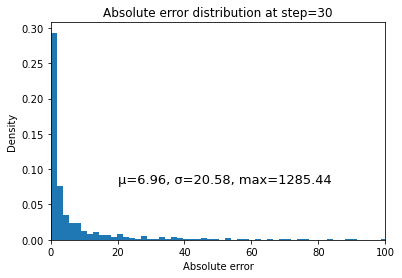

In [138]:
device = torch.device("cuda:0")
best_model_path = trainer.checkpoint_callback.best_model_path
best_model = RNN.load_from_checkpoint(best_model_path).to(device)
print(best_model_path)
print(best_model.device)
predictions = best_model.predict(test_dataloader, batch_size=500, show_progress_bar=True)
print(predictions.shape)
actuals = torch.cat([y[0] for _, y in iter(test_dataloader)])
mask = actuals > 1.0
abs_error = torch.abs(predictions - actuals)
abs_error.shape
print(torch.mean(abs_error * mask))
abs_error_steps = torch.mean(abs_error * mask, dim=0)
abs_error_steps.shape
mape = abs_error / (actuals + 1e-5)
print(torch.mean(mape * mask))
mape_steps = torch.mean(mape * mask, dim=0)
n = abs_error.shape[0]
step = 30 # 30 mins later

abs_error_step = abs_error[:, step-1] * mask[:, step-1]

σ, μ = torch.std_mean(abs_error_step)
print(f"μ = {μ:.4f}, σ = {σ:.4f}, max = {abs_error_step.max():.4f}, error rate = {μ/carpark_data_non_HDB.groupby(['sid'])['AvailableLots'].max().mean():.4f}")
xs = abs_error_step[torch.randperm(n)[:1000]].cpu().numpy()
n = len(abs_error_step)
plt.hist(xs, 100, density=True)
plt.xlim(0, 100)
plt.xlabel("Absolute error")
plt.ylabel("Density")
plt.text(20, 0.08, f"μ={μ:.2f}, σ={σ:.2f}, max={abs_error_step.max():.2f}",
         fontsize=13)
plt.title(f"Absolute error distribution at step={step}");

Calculate the average carpark volume

In [139]:
print(carpark_data_HDB.groupby(['sid'])['AvailableLots'].max().mean())
print(carpark_data_non_HDB.groupby(['sid'])['AvailableLots'].max().mean())
print(carpark_data.groupby(['sid'])['AvailableLots'].max().mean())

255.40707364341085
308.239837398374
258.9330801229879
